In [46]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time
from tqdm.notebook import tqdm

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.constraints import *
from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.table.grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.parameter_estimation import *
from spatial_scene_grammars.dataset import *

import meshcat
import meshcat.geometry as meshcat_geom

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
if 'vis' not in globals():
    vis = meshcat.Visualizer()
vis.delete()
base_url = "http://127.0.0.1"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)
'''
from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))
'''

Meshcat url:  http://127.0.0.1:7003/static/


'\nfrom IPython.display import HTML\nHTML("""\n    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">\n    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>\n</div>\n""".format(url=meshcat_url))\n'

In [48]:
# Load and draw scene
with open("example_feasible_sampled_scene.pickle", "rb") as f:
    tree = pickle.load(f)
draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url,  prefix="tree/contents")
draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url,  prefix="tree/structure")

In [49]:
from blender_server.drake_blender_visualizer.blender_visualizer import (
    BlenderColorCamera
)

In [50]:
# Figure out where we're putting the camera for the scene by
# pointing it inwards, and then applying a yaw around
# the origin.
cam_quat_base = RollPitchYaw(
    68.*np.pi/180.,
    0.*np.pi/180,
    38.6*np.pi/180.).ToQuaternion()
cam_trans_base = np.array([1.19, -1.4, 1.64])
cam_tf_base = RigidTransform(quaternion=cam_quat_base,
                        p=cam_trans_base)
# Rotate camera around origin
cam_additional_rotation = RigidTransform(
    quaternion=RollPitchYaw(0., 0., 0.).ToQuaternion(),
    p=[0, 0, 0]
)
cam_tf_base = cam_additional_rotation.multiply(cam_tf_base)
cam_tfs = [cam_tf_base]

builder, mbp, scene_graph, _, _, = compile_scene_tree_to_mbp_and_sg(tree)
mbp.Finalize()
blender_vis = builder.AddSystem(BlenderColorCamera(
    scene_graph,
    draw_period=0.03333/2.,
    camera_tfs=cam_tfs,
    zmq_url="tcp://127.0.0.1:5556",
    env_map_path="/home/gizatt/tools/blender_server/data/env_maps/bush_restaurant_4k.exr",
    out_prefix=os.path.join(os.getcwd(),"renders/"),
    resolution=[640*2, 480*2],
    cam_fov=np.pi/4,
    save_scene=True
))
builder.Connect(scene_graph.get_query_output_port(),
                blender_vis.get_input_port(0))
diagram = builder.Build()
context = diagram.CreateDefaultContext()
blender_vis.load()
context.SetTime(5.0)
diagram.Publish(context)

Connecting to blender server at zmq_url=tcp://127.0.0.1:5556...
Connected to Blender server.
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
In publish at time  5.0
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'S

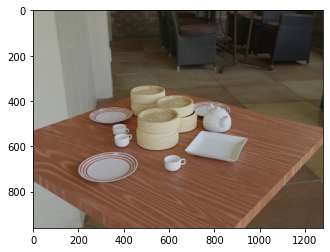

In [51]:
plt.imshow(plt.imread("renders/%02d_%08d.jpg" % (0, 0)))

# Render all scenes in a sample set from top-down view

In [100]:
trees_to_draw = []
with open("target_dataset_examples.pickle", "rb") as f:
    while 1:
        try:
            trees_to_draw.append(pickle.load(f))
        except EOFError:
            break
print("Loaded %d environments" % len(trees_to_draw))

Loaded 100 environments


In [60]:
# Point camera straight down at scene
out_folder = "post_fit_pre_sim"
for k, tree in tqdm(enumerate(trees_to_draw), total=len(trees_to_draw)):
    from pydrake.all import Quaternion
    cam_tfs = [RigidTransform(p=[0.,0.,3.2], quaternion=Quaternion([0., 0., 0., 1.]))]
    builder, mbp, scene_graph, _, _, = compile_scene_tree_to_mbp_and_sg(tree)
    mbp.Finalize()
    blender_vis = builder.AddSystem(BlenderColorCamera(
        scene_graph,
        draw_period=0.03333/2.,
        camera_tfs=cam_tfs,
        zmq_url="tcp://127.0.0.1:5556",
        env_map_path="/home/gizatt/tools/blender_server/data/env_maps/bush_restaurant_4k.exr",
        out_prefix=os.path.join(os.getcwd(),"renders/%s/%04d/" % (out_folder, k)),
        resolution=[640*2, 480*2],
        cam_fov=np.pi/4,
        save_scene=False,
        raytraced=True
    ))
    builder.Connect(scene_graph.get_query_output_port(),
                    blender_vis.get_input_port(0))
    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    blender_vis.load()
    context.SetTime(5.0)
    diagram.Publish(context)

  0%|          | 0/50 [00:00<?, ?it/s]

Connecting to blender server at zmq_url=tcp://127.0.0.1:5556...
Connected to Blender server.
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
In publish at time  5.0
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
Rendered a frame at 5.000000 seconds sim-time.
Connecting to blender server at zmq_url=tcp://127.0.0.1:5556...
Connected to Blender server.
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
In publish at time  5.0
b'Success'
b'Success'
b'Su

KeyboardInterrupt: 

In [101]:
# Point camera at scene in a scenic way
out_folder = "examples_scenic"
for k, tree in tqdm(enumerate(trees_to_draw[:30]), total=len(trees_to_draw)):
    from pydrake.all import Quaternion
    q = np.array([0.783, 0.527, .185, .274])
    q = q / np.linalg.norm(q)
    cam_tfs = [RigidTransform(p=[1.125, -1.4112, 1.5119], quaternion=Quaternion(q))]
    builder, mbp, scene_graph, _, _, = compile_scene_tree_to_mbp_and_sg(tree)
    mbp.Finalize()
    blender_vis = builder.AddSystem(BlenderColorCamera(
        scene_graph,
        draw_period=0.03333/2.,
        camera_tfs=cam_tfs,
        zmq_url="tcp://127.0.0.1:5556",
        env_map_path="/home/gizatt/tools/blender_server/data/env_maps/bush_restaurant_4k.exr",
        out_prefix=os.path.join(os.getcwd(),"renders/%s/%04d/" % (out_folder, k)),
        resolution=[640*2, 480*2],
        cam_fov=np.pi/4,
        save_scene=False,
        raytraced=True
    ))
    builder.Connect(scene_graph.get_query_output_port(),
                    blender_vis.get_input_port(0))
    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    blender_vis.load()
    context.SetTime(5.0)
    diagram.Publish(context)

  0%|          | 0/100 [00:00<?, ?it/s]

Connecting to blender server at zmq_url=tcp://127.0.0.1:5556...
Connected to Blender server.
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
In publish at time  5.0
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
Rendered a frame at 5.000000 seconds sim-time.
Connecting to blender server at zmq_url=tcp://127.0.0.1:5556...
Connected to Blender server.
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Succ

b'Success'
Rendered a frame at 5.000000 seconds sim-time.
Connecting to blender server at zmq_url=tcp://127.0.0.1:5556...
Connected to Blender server.
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
In publish at time  5.0
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
Rendered a frame at 5.000000 seconds sim-time.
Connecting to blender server at zmq_url=tcp://127.0.0.1:5556...
Connected to Blender server.
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'S

b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
In publish at time  5.0
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
Rendered a frame at 5.000000 seconds sim-time.
Connecting to blender server at zmq_url=tcp://127.0.0.1:5556...
Connected to Blender server.
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'
b'Success'


KeyboardInterrupt: 

# Load all images and render an "average" image
 

Text(0.5, 1.0, 'Overlay of 5 post-fit scenes, post-sim')

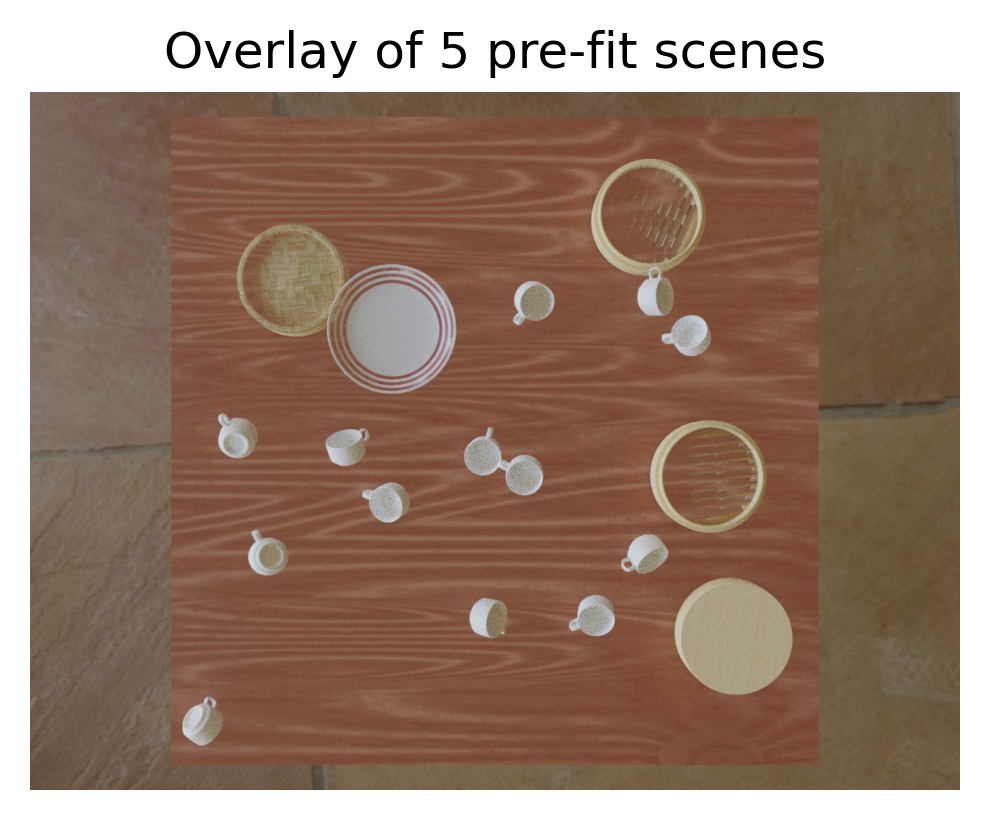

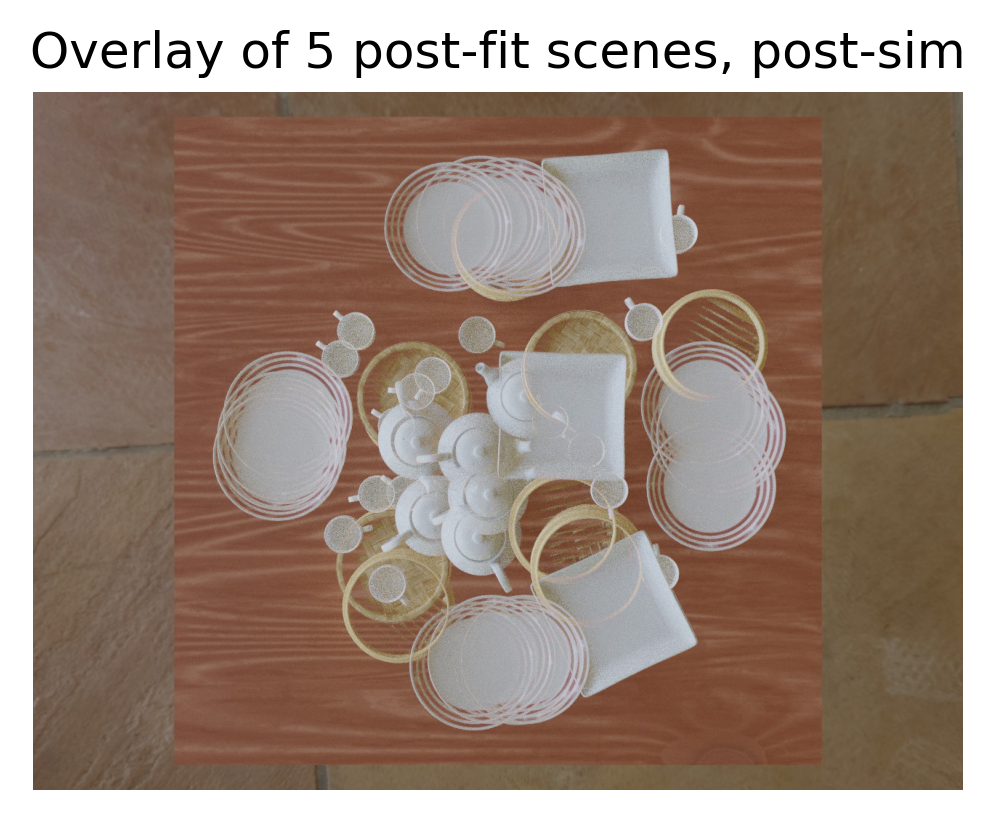

In [96]:
import glob
import cv2

def load_im(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_RGB2BGR).astype(np.float)/255.

def get_average_image(glob_string, background_path):
    im_paths = glob.glob(glob_string)[:5]
    background_image = load_im(background_path)
    ims = [load_im(path) - background_image for path in im_paths]
    return np.max(np.stack(ims, axis=0), axis=0) + background_image, len(im_paths)
    
    
plt.figure(dpi=300).set_size_inches(4, 4)
avg_im, N = get_average_image(glob_string = "renders/pre_fit/**/*.jpg", background_path="renders/table_background.jpg")
plt.imshow(avg_im)
plt.axis('off')
plt.title("Overlay of %d pre-fit scenes" % N)

plt.figure(dpi=300).set_size_inches(4, 4)
avg_im, N = get_average_image(glob_string = "renders/post_fit_post_sim/**/*.jpg", background_path="renders/table_background.jpg")
plt.imshow(avg_im)
plt.axis('off')
plt.title("Overlay of %d post-fit scenes, post-sim" % N)

# Render video with ffmpeg call

In [84]:
glob_string = "renders/post_fit_post_sim/**/*.jpg"
file_paths = glob.glob(glob_string)[:20]
out_filename = "renders/post_fit_post_sim_top_down.mp4"
file_path_filename = "file_paths.txt"
with open(file_path_filename, "w") as f:
    for file_path in file_paths:
        f.write("""file %s\n""" % file_path)

ffmpeg_call = "ffmpeg -y -r 2 -f concat -i %s -c:v libx264 -pix_fmt yuv420p -vf \"scale=1024:1024\" %s" % (
    file_path_filename, out_filename
)
print(ffmpeg_call)
os.system(ffmpeg_call)


ffmpeg -y -r 2 -f concat -i file_paths.txt -c:v libx264 -pix_fmt yuv420p -vf "scale=640:640" renders/post_fit_post_sim_top_down.mp4


0

In [106]:
glob_string = "renders/post_fit_post_sim_scenic/**/*.jpg"
file_paths = glob.glob(glob_string)[:20]
out_filename = "renders/post_fit_post_sim_scenic.mp4"
file_path_filename = "file_paths.txt"
with open(file_path_filename, "w") as f:
    for file_path in file_paths:
        f.write("""file %s\n""" % file_path)

ffmpeg_call = "ffmpeg -y -r 2 -f concat -i %s -c:v libx264 -pix_fmt yuv420p -vf \"scale=1024:1024, crop=1024:700:0:100\" %s" % (
    file_path_filename, out_filename
)
print(ffmpeg_call)
os.system(ffmpeg_call)


ffmpeg -y -r 2 -f concat -i file_paths.txt -c:v libx264 -pix_fmt yuv420p -vf "scale=1024:1024, crop=1024:700:0:100" renders/post_fit_post_sim_scenic.mp4


0

In [108]:
glob_string = "renders/pre_fit_scenic/**/*.jpg"
file_paths = glob.glob(glob_string)[:20]
out_filename = "renders/pre_fit_scenic.mp4"
file_path_filename = "file_paths.txt"
with open(file_path_filename, "w") as f:
    for file_path in file_paths:
        f.write("""file %s\n""" % file_path)

ffmpeg_call = "ffmpeg -y -r 2 -f concat -i %s -c:v libx264 -pix_fmt yuv420p -vf \"scale=1024:1024, crop=1024:700:0:100\" %s" % (
    file_path_filename, out_filename
)
print(ffmpeg_call)
os.system(ffmpeg_call)


ffmpeg -y -r 2 -f concat -i file_paths.txt -c:v libx264 -pix_fmt yuv420p -vf "scale=1024:1024, crop=1024:700:0:100" renders/pre_fit_scenic.mp4


0

In [107]:
glob_string = "renders/examples_scenic/**/*.jpg"
file_paths = glob.glob(glob_string)[:20]
out_filename = "renders/examples_scenic.mp4"
file_path_filename = "file_paths.txt"
with open(file_path_filename, "w") as f:
    for file_path in file_paths:
        f.write("""file %s\n""" % file_path)

ffmpeg_call = "ffmpeg -y -r 2 -f concat -i %s -c:v libx264 -pix_fmt yuv420p -vf \"scale=1024:1024, crop=1024:700:0:100\" %s" % (
    file_path_filename, out_filename
)
print(ffmpeg_call)
os.system(ffmpeg_call)


ffmpeg -y -r 2 -f concat -i file_paths.txt -c:v libx264 -pix_fmt yuv420p -vf "scale=1024:1024, crop=1024:700:0:100" renders/examples_scenic.mp4


0